# Objectively choosing where to live

The purpose of this notebook is to prepare, analyse and visualize the data necessary to give an informed answer to the following question:  **If you could choose a country to move to, what would that country be?**

The notebook uses data from three sources: 
* World Bank indicators: https://data.worldbank.org/indicator?tab=all
* Numbeo quality of life data: https://www.numbeo.com/quality-of-life/rankings_by_country.jsp
* Worldometers country population data: https://www.worldometers.info/world-population/population-by-country/ 

The data is cleaned and filtered so that only a few countries of interest (my personal favorites) are compared based on a few pre-selected criteria. 
Future use is welcomed: you just have to select your countries of interest and your criteria of interest.

So...where would you move to?

# Imports

First up, load all the necessary packages.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re # regular expressions
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting

# Data loading 1

Load the world development indicators (WDI) data and select the criteria of interest.
The World Development Indicators from the World Bank contain over a thousand annual indicators of economic development from hundreds of countries around the world. Using all these indicators in our analysis, while ideal, is unfeasable. For this notebook I only use a few, mostly focused on *Health*, *Economy* and *General wellbeing*. Furthermore, I only look at the last 8 years.

Finding the relevant indicators is not straightforward given the size of the data. Krishna Ravikumar's notebook from [here](https://www.kaggle.com/kmravikumar/choosing-topics-to-explore)
 comes in handy.

In [20]:
wdi_full_data = pd.read_csv('../input/wdi-indicators-data/WDIData.csv')
indicator_list = wdi_full_data[['Indicator Name','Indicator Code']].drop_duplicates().values

# This part is inspired from here: https://www.kaggle.com/kmravikumar/choosing-topics-to-explore
modified_indicators = []
unique_indicator_codes = []
for ele in indicator_list:
    indicator = ele[0]
    indicator_code = ele[1].strip()
    if indicator_code not in unique_indicator_codes:
        new_indicator = re.sub('[,()]',"",indicator).lower()
        new_indicator = re.sub('-'," to ",new_indicator).lower()
        modified_indicators.append([new_indicator,indicator_code])
        unique_indicator_codes.append(indicator_code)
indicators = pd.DataFrame(modified_indicators,columns=['Indicator Name','Indicator Code']).drop_duplicates()

# Indicators of interest

Select the relevant indicators and columns.
This notebook can easily be reused with other indicators.

In [35]:
selected_health_indicators = [('life expectancy at birth total years', 'SP.DYN.LE00.IN'),
                              ('mortality rate adult female per 1000 female adults', 'SP.DYN.AMRT.FE'),
                              ('mortality rate adult male per 1000 male adults', 'SP.DYN.AMRT.MA'),
                              ('mortality rate infant per 1000 live births', 'SP.DYN.IMRT.IN'),
                              ('current health expenditure % of gdp', 'SH.XPD.CHEX.GD.ZS')]

selected_economy_indicators = [('gdp per capita ppp constant 2011 international $', 'NY.GDP.PCAP.PP.KD'),
                               ('employment to population ratio 15+ total % national estimate', 'SL.EMP.TOTL.SP.NE.ZS'),
                               ('income share held by third 20%', 'SI.DST.03RD.20')]

selected_indicators = selected_health_indicators + selected_economy_indicators
selected_countries = ['Belgium', 'Denmark', 'France', 'Germany', 'Switzerland', 'Spain', 'Netherlands', 'United States', 
                      'Portugal', 'Romania', 'United Kingdom', 'Austria', 'Norway']

wdi_data = wdi_full_data[wdi_full_data['Country Name'].isin(selected_countries) & 
                         wdi_full_data['Indicator Code'].isin([ind[1] for ind in selected_indicators])].copy()
wdi_data = wdi_data.drop(['Country Code', 'Indicator Name', 'Unnamed: 64'], axis=1)

# Fill in missing values 1

This is done in two steps. Firstly, data is reshaped so that each indicator represents a column. Then, the data is grouped by the country and *linearly* interpolated (i.e., missing values are replaced with new values based on their neighbours). By default, in *linear* interpolation the missing values are filled up by two nearest position values.

Note here that a missing value in one indicator is replaced with a new value computed based on the values of **the same indicator** from other years (1960-2019), measured for **the same country**. 

In [36]:
# Reshape the data so that later imputation of missing values is easy.
wdi_data = wdi_data.melt(id_vars=['Country Name', 'Indicator Code'], 
                    value_vars=wdi_data.columns.difference(['Country Name', 'Indicator Code']), 
                                var_name='Year', value_name='Indicator Value')
wdi_data = wdi_data.set_index(['Country Name', 'Year', 'Indicator Code'])['Indicator Value'].unstack().reset_index().rename_axis(None, axis=1)

# Fill in missing values.
for country in set(wdi_data['Country Name']):
    country_slice = wdi_data[wdi_data['Country Name'] == country].copy()
    country_slice.iloc[:, 2:] = country_slice.iloc[:, 2:].interpolate(method='linear', limit_direction='both', axis=0)
    wdi_data[wdi_data['Country Name'] == country] = country_slice

# Select relevant years

Finally, only measurements from the last 8 years are used. Although this may seem controversial, I chose to only use the last 8 years because some countries have undergone major changes in some aspects over the last decades. For example, some countries performed moderately well economically in the 80's but are much more powerful now. Given that later on in the analysis I will be using the average of indicator values, using the full data may affect the results returned for those countries that have skewed values over the available period.

In [37]:
selected_years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
wdi_data = wdi_data[wdi_data['Year'].isin(selected_years)]

# Data loading 2

Load the data from [Numbeo](https://www.numbeo.com/) that offers more general indicators such as *Quality of life*, *Safety*, *Purchasing power*, etc. for various countries over a period of, conveniently enough, 8 years :). (I confess: the use of the last 8 years of world development indicators has also been informed by this 8-year limit in the Numbeo data for consitency).

In [38]:
numbeo_data = pd.read_csv('../input/numbeo-data/numbeo_qol.csv')
numbeo_data = numbeo_data[numbeo_data['Country Name'].isin(selected_countries)].copy().reset_index()

# Fill in missing values 2

As before, missing values are replaced with new values computed for the same country in other years.

In [39]:
for country in set(numbeo_data['Country Name']):
    country_slice = numbeo_data[numbeo_data['Country Name'] == country].copy()
    country_slice.iloc[:, 2:] = country_slice.iloc[:, 2:].interpolate(method='linear', limit_direction='both', axis=0)
    numbeo_data[numbeo_data['Country Name'] == country] = country_slice
numbeo_data = numbeo_data.drop(['index'], axis=1)

# Data loading 3

Before we begin our analysis, load the population data: the number of inhabitants for each country. This data is mostly already cleaned and it is used only as a cosmetic feature (i.e., it is not part of the analysis).

In [40]:
pop_data = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv').iloc[:, 0:2]
pop_data.rename(columns={'Country (or dependency)': 'Country Name', 'Population (2020)': 'Population'}, inplace=True)

# Health expenditure vs. Life expectancy analysis

One criterion that interests me and that I consider worth factoring in when deciding where to live is the health system of the destination. One indicator in the WDI data that may be of interest in measuring the *health of the health system* is the proportion of GDP each country allocates for their health. Here it is a view of this measure, plotted against the average life expectancy in each country. Surely, the connection between the two is much deeper and more complex to analyse than this simple graph, but this could be a good start.

Each point on the graph represents a country and its size is given by the GDP per capita of that country.

This plot style and similar ones from the rest of this notebook are inspired by the awesome [Gapminder](https://www.gapminder.org/).

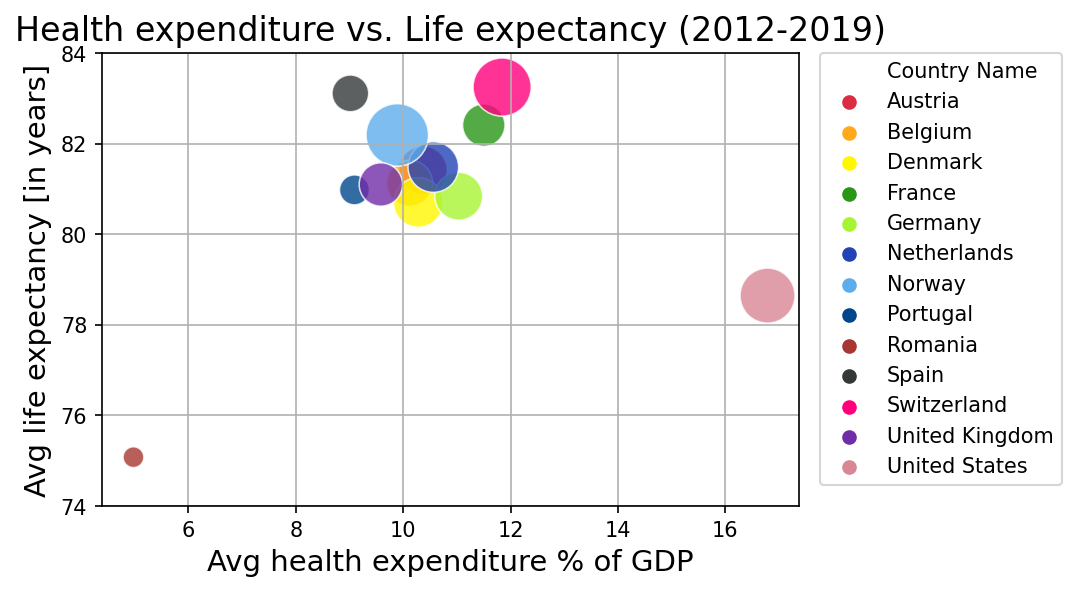

In [53]:
# Select the relevant data
df = wdi_data[['Country Name', 'SH.XPD.CHEX.GD.ZS', 'SP.DYN.LE00.IN', 'NY.GDP.PCAP.PP.KD']]

# Group WDI data by the country
health_exp_life_exp = df.groupby(['Country Name']).mean().reset_index()

# Create the plot
plt.figure(dpi=150)
colors = ["#DA2C43", "#FFAA1D", "#FFF700", "#299617", "#A7F432", "#2243B6", "#5DADEC", "#00468C", "#A83731", "#353839",
         "#FF007C", "#6F2DA8", "#D98695"]
ax = sns.scatterplot(health_exp_life_exp['SH.XPD.CHEX.GD.ZS'], health_exp_life_exp['SP.DYN.LE00.IN'], 
            hue = health_exp_life_exp['Country Name'], size = health_exp_life_exp['NY.GDP.PCAP.PP.KD'].to_numpy() * 2, 
                sizes=(100,900), alpha = 0.8, palette = colors)
plt.xlabel('Avg health expenditure % of GDP', fontsize = 14)
plt.ylabel('Avg life expectancy [in years]', fontsize = 14)
plt.title('Health expenditure vs. Life expectancy (2012-2019)', fontsize = 16)
plt.ylim(74, 84)
plt.grid(True)
h,l = ax.get_legend_handles_labels()
plt.legend(h[:health_exp_life_exp.shape[0]+1], l[:health_exp_life_exp.shape[0]+1], bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., fancybox=True)
plt.show()

# Health care and pollution analysis

On the same note of health system analysis, [Numbeo](https://www.numbeo.com/) offers more general indices. For example, a *health care index* as an estimation of the overall quality of the health care system, health care professionals, equipment, staff, doctors, cost, etc. More details about the index can be found [here](https://www.numbeo.com/health-care/indices_explained.jsp).

Lastly, because one's health is directly impacted by the amount of existing pollution, a *pollution index* seemed like a good measurement to factor in in my analysis.

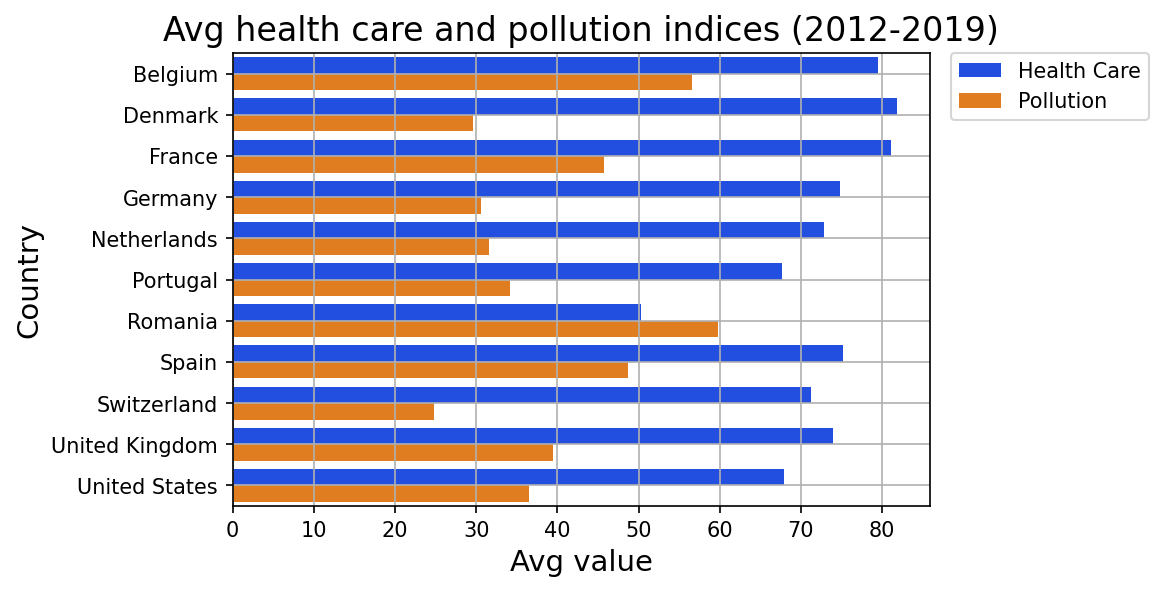

In [28]:
# Select the relevant data
df = numbeo_data[['Country Name', 'Health Care', 'Pollution']].groupby(['Country Name']).mean().reset_index()

# Reshape the data to a format consistent with the graph style
health_pollution = df.melt('Country Name', var_name='Indices', value_name='Value')

# # Create the plot
plt.figure(dpi=150)
ax = sns.barplot(y="Country Name", x="Value", hue="Indices", data=health_pollution, 
                 palette = sns.color_palette("bright"))
plt.xlabel('Avg value', fontsize = 14)
plt.ylabel('Country', fontsize = 14)
plt.title('Avg health care and pollution indices (2012-2019)', fontsize = 16)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., fancybox=True)
plt.show()

# GDP vs. Middle class income share

One other factor that I consider important when choosing the country to live in is the economical one. Of course, many criteria can be considered here to analyse a country's economy. In fact, WDI data offers a plethora of economical indicators from reliable sources that can be used for economic analysis. Two such indicators got my attention. Firstly, the GDP per capita as a measure of the overall wealth of the country. Then, compare this against the percentage share of income or consumption that accrues to subgroups of population indicated by deciles or quintiles. Since I consider myself being part of the middle class, I will use here the indicator for the share of income held by the **third 20%** of the population. Here is the graph.

Each point on the graph represents a country and its size is given by the population of that country.

This plot style and similar ones from the rest of this notebook are inspired by the awesome [Gapminder](https://www.gapminder.org/).

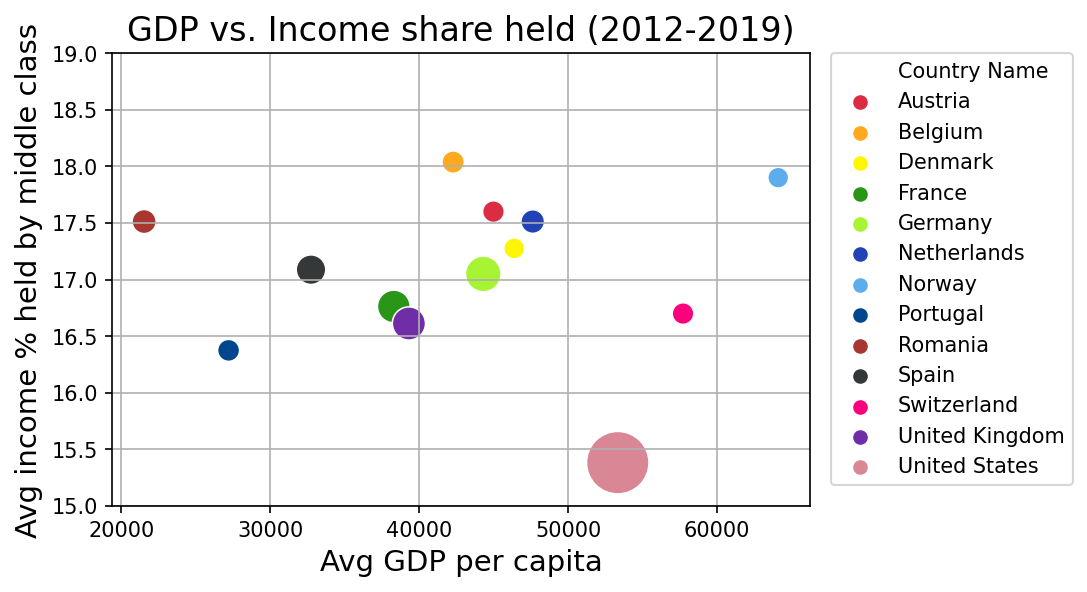

In [57]:
# Select the relevant data
df = wdi_data[['Country Name', 'NY.GDP.PCAP.PP.KD', 'SI.DST.03RD.20']]

# Join the WDI data and the population data
employment_gdp = pd.merge(df.groupby(['Country Name']).mean().reset_index(), pop_data, on='Country Name')

# Create the plot
plt.figure(dpi=150)
colors = ["#DA2C43", "#FFAA1D", "#FFF700", "#299617", "#A7F432", "#2243B6", "#5DADEC", "#00468C", "#A83731", "#353839",
         "#FF007C", "#6F2DA8", "#D98695"]
ax = sns.scatterplot(employment_gdp['NY.GDP.PCAP.PP.KD'], employment_gdp['SI.DST.03RD.20'], 
            hue = employment_gdp['Country Name'], size = employment_gdp['Population'].to_numpy() * 2, 
                sizes=(100,900), alpha = 1, palette = colors)
plt.xlabel('Avg GDP per capita', fontsize = 14)
plt.ylabel('Avg income % held by middle class', fontsize = 14)
plt.title('GDP vs. Income share held (2012-2019)', fontsize = 16)
plt.grid(True)
plt.ylim(15, 19)
h,l = ax.get_legend_handles_labels()
plt.legend(h[:employment_gdp.shape[0]+1], l[:employment_gdp.shape[0]+1], bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., fancybox=True)
plt.show()

# Purchassing power and cost of living analysis

Keeping the ball in the economy court, I wonder if the cost of living and/or purchasing power have anything to say in our analysis. Here it is with data from [Numbeo](https://www.numbeo.com/). Details about the indices can be found [here](https://www.numbeo.com/cost-of-living/cpi_explained.jsp).


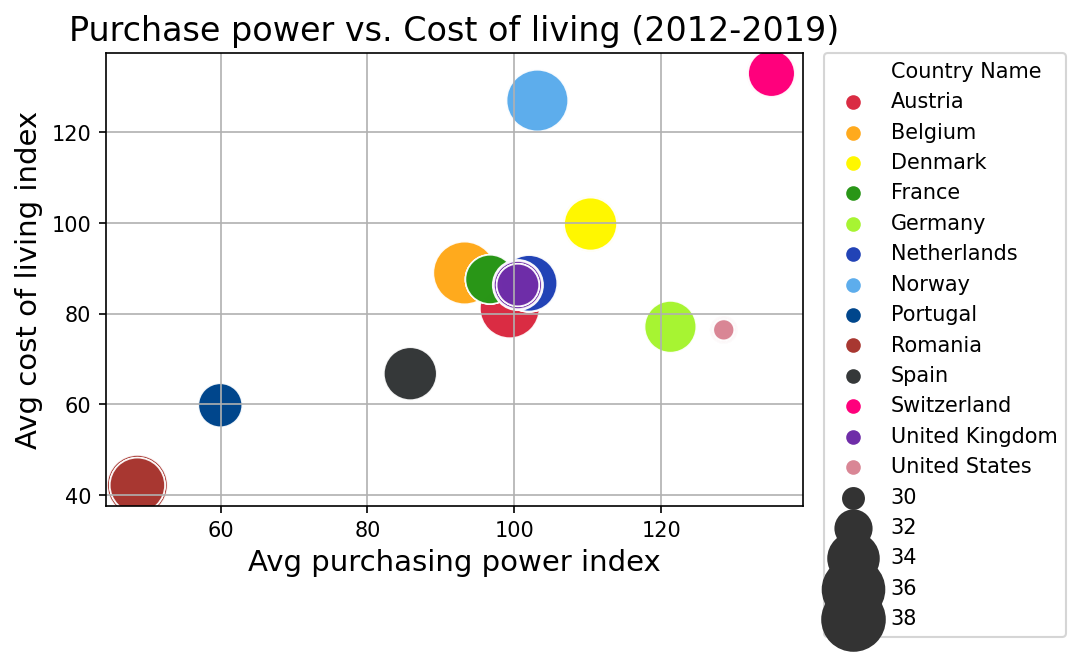

In [59]:
# Select the relevant data
df = numbeo_data[['Country Name', 'Purchasing Power', 'Cost of Living']]

# Reshape the data to a format consistent with the graph style
pp_col = pd.merge(df.groupby(['Country Name']).mean().reset_index(), pop_data, on='Country Name')

# Create the plot
plt.figure(dpi=150)
colors = ["#DA2C43", "#FFAA1D", "#FFF700", "#299617", "#A7F432", "#2243B6", "#5DADEC", "#00468C", "#A83731", "#353839",
         "#FF007C", "#6F2DA8", "#D98695"]
ax = sns.scatterplot(pp_col['Purchasing Power'], pp_col['Cost of Living'], 
            hue = pp_col['Country Name'], size = pp_col['Population'].to_numpy() * 2, 
                sizes=(100,900), alpha = 0.9, palette = colors)
plt.xlabel('Avg purchasing power index', fontsize = 14)
plt.ylabel('Avg cost of living index', fontsize = 14)
plt.title('Purchase power vs. Cost of living (2012-2019)', fontsize = 16)
plt.grid(True)
h,l = ax.get_legend_handles_labels()
plt.legend(h[:pp_col.shape[0]+1], l[:pp_col.shape[0]+1], bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., fancybox=True)
plt.show()

# Quality of life and safety analysis

Lastly, I wonder what does a more general analysis of quality of life and safety would tell us about the countries under analysis.

Again, data is from [Numbeo](https://www.numbeo.com/) and details about the indices can be found [here](https://www.numbeo.com/quality-of-life/indices_explained.jsp).

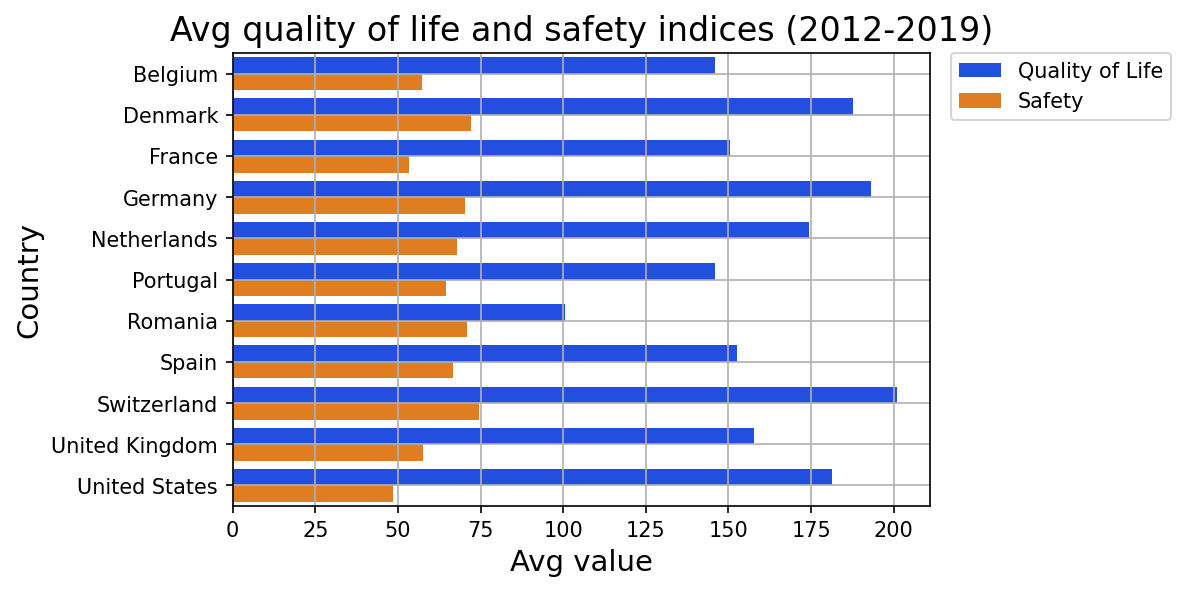

In [31]:
# Select the relevant data
df = numbeo_data[['Country Name', 'Quality of Life', 'Safety']].groupby(['Country Name']).mean().reset_index()

# Reshape the data to a format consistent with the graph style
qol_safety = df.melt('Country Name', var_name='Indices', value_name='Value')

# Create the plot
plt.figure(dpi=150)
ax = sns.barplot(y="Country Name", x="Value", hue="Indices", data=qol_safety, 
                 palette = sns.color_palette("bright"))
plt.xlabel('Avg value', fontsize = 14)
plt.ylabel('Country', fontsize = 14)
plt.title('Avg quality of life and safety indices (2012-2019)', fontsize = 16)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., fancybox=True)
plt.show()